<a href="https://colab.research.google.com/github/VivianKingasia/Mobile-Phone-Sentiment-Analysis/blob/main/Mobile_Phone_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Business Understanding

## 1.1. Problem Statement

Purchasing a product is an interaction between two entities, consumers and business owners. Consumers often use reviews to make decisions about what products to buy, while businesses, on the other hand, not only want to sell their products but also want to receive feedback in terms of consumer reviews. Consumer reviews about purchased products shared on the internet have a great impact. Human nature is generally structured to make decisions based on analyzing and getting the benefit of other consumer experience and opinions because others often have a great influence on our beliefs, behaviors, perception of reality, and the choices we make. Hence, we ask others for their feedback whenever we are deciding on doing something. Additionally, this fact applies not only to consumers but also to organizations and institutions.

As social media networks have evolved, so have the ways that consumers express their opinions and feelings. With the vast amount of data now available online, it has become a challenge to extract useful information from it all. Sentiment analysis has emerged as a way to predict the polarity (positive, negative, or neutral) of consumer opinion, which can help consumers better understand the textual data.

E-commerce websites have increased in popularity to the point where consumers rely on them for buying and selling. These websites give consumers the ability to write comments about different products and services, which has resulted in a huge amount of reviews becoming available. Consequently, the need to analyze these reviews to understand consumers’ feedback has increased for both vendors and consumers. However, it is difficult to read all the feedback for a particular item, especially for popular items with many comments. 

In this research, we attempt to build a predictor for consumers’ satisfaction on mobile phone products based on the reviews. We will also attempt to understand the factors that contribute to classifying reviews as positive, negative or neutral (based on important or most frequent words). This is believed to help companies improve their products and also help potential buyers make better decisions when buying products.


### 1.1.1. Main objective

- To perform a sentiment analysis of mobile phone reviews from Amazon website to determine how these reviews help consumers to have conﬁdence that they have made the right decision about their purchases.

### 1.1.2. Specific Objectives

- To help companies understand their consumers’ feedback to maintain their products/services or enhance them.
- To provide insights to companies in curating offers on speciﬁc products to increase their proﬁts and customer satisfaction.
- To understand the factors that contribute to classifying reviews as positive, negative or neutral (based on important or most frequent words).
- To determine mobile phones key features that influence smartphone purchases.
- To perform a market segmentation of consumers based on their reviews
- To advise the advertisement department in companies on these key features to use as selling points and to specific customer segments  in upcoming advertisements.

### 1.1.3. Metrics of Success

The best performing model will be selected based on:
- An accuracy score > 80%
- An F1 score > 0.85 


# 2. Data Understanding

The data used for this project is obtained from [data.world](https://data.world/promptcloud/amazon-mobile-phone-reviews) and contains more than 400 thousand reviews  of unlocked mobile phones sold on [amazon.com](https://www.amazon.com/). The data was collected from 2016 and last updated in April 2022. The data contains 6 columns:
- Product_name : Contains the name of the product
- Brand : Contains the brand of the product
- Price : Contains the price of the brans
- Rating : Contains the rating awarded to that product
- Reviews : Contains the review of that product
- Review_votes : Number of people who found the review helpful



# 3. Loading Relevant Libraries & Data

## 3.1. Loading Libraries

In [49]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS


import nltk
import string
import re
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, word_tokenize


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

!pip install contractions
import contractions

# nltk downloads
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('tagsets', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


True

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.2. Loading Data

In [51]:
# loading the data

df = pd.read_csv('/content/drive/Shareddrives/Alpha/Data/Amazon Combined Data.csv')
df.head()

,Rating,Review Title,Review,Location and Date of Review,Affiliated Company,Brand and Features,Price
0,4.0 out of 5 stars,"\n.. not what ordered, not New... but it works so far\n","\nSo first off...it's not what I ordered, but I don't really care as it's a burner.I ordered the ""Gold"" version. I got a ""Black"" version. Hardware and (assumed) function are the same. I say assumed, as I have not used it for the purposes it was purchased for.However, as far as the ""Phone"" goes, it's functional, and does what most modern phones do. It was running Android 10, so not much to complain about, but no stock Service provider forced apps, other than the ones that come with the custom RCA ROM. Can't be bothered to root it, but can be done fairly easily, if you look in the usual places for info.I totally missed the ""like new"" as condition!! Can't really be surprised at the price point, and though the wrong color, looks pristine! No scuffs, bumps, cracks or scrapes. The only way is know it was not new, is the package ( see pict).Totally on me. Still...if wrong color..might other things, as others have pointed out, raise up and bite me?It's a burner, not intended to fly the space shuttle remotely over a VPN...We will see I guess ..Now, the good stuff, what there is of it.It's an Android. Works(so far) out of the box, with minimal need for difficult set up or account creation. The Android process walks you through set up. Android 10 + have a number of security and privacy configurations that have been brought to the front, so it's much easier to manage privacy, tracking, and security options than previous Android os's.It's not fast. In fact, with stock build that came with device, even prior to the one app installed so far, I have seen lag time between action and response. Sooo.. do t think this device is gonna let you run 15 appa, split screen, while playing music and talking to your Memaw...it won't. Not RCAs fault, that memory and chip. Still, compared to a phone that is 3 yrs older with similar hardware, it's slow. I don't care. You may... Consider your sled advised, if you get this far.Otherwise, though a bit small on screen size, I like it in the limited time I've messed with it.Of note for some, it doesn't have gorilla glass, obviously for thai Price point. It did however come with a Pre-installed screen protector. Did come with, as far as I can tell a new, mostly charged battery, basic headphones, and a... pretty ...no, super basic clear rubber/ plastic case cover. So there is that.Not alot of info here, sorry, I'll know more when I use it instead of the $700 daily phone.It will do what you'd expect a phone to do, duel sim, yadada, and though not advertised, apparently takes up to a128gb micro SIM....Not trusting that info, waiting on a 64gm SIM figuring it should work.If it sucks or goes pear shaped at the wrong time ..I'll update this review.\n","Reviewed in the United States on February 11, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, Android 11, Black - GSM Unlocked",$69.99
1,3.0 out of 5 stars,\nNot for Cricket Wireless and this two reviews on two different RCA phones\n,"\nThe phone itself is a okay android device, but since Cricket Wireless has changed their networks it will not work on that carrier. If you’re using Cricket Wireless and you put your sim card in this phone they will cut that phone line off.I didn’t know Cricket Wireless was starting to control what phone you can or can't use and if I did I would have not ordered this phone.Pros:1. Nice looking phone2. The speed of the phone is ok by using liter apps3. The phone charges up pretty fastCons:1. The phone will not work with Cricket Wireless2. The battery life is not the best3: The Camera is the worst I ever seen on any smartphone, it’s like using a flip phone camera. The pictures will come out looking very bad and there’s no way to fix that. It doesn’t matter how good the lighting is the pictures will still come out dark and difficult to make out.E

## 3.3. Previewing Data

In [52]:
# checking the shape of the data

print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')

The data has 17198 rows and 7 columns


In [53]:

# checking the data types of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17198 entries, 0 to 17197
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Rating                       17198 non-null  object
 1   Review Title                 17198 non-null  object
 2   Review                       17168 non-null  object
 3   Location and Date of Review  17198 non-null  object
 4   Affiliated Company           17198 non-null  object
 5   Brand and Features           17198 non-null  object
 6   Price                        17198 non-null  object
dtypes: object(7)
memory usage: 940.6+ KB


# 4. Data Cleaning

## 4.1. Missing values
- Checking for missing values


In [54]:
# Define a function to get missing data
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data>0]
    return missing_data

In [55]:
# Getting the sum of missing values per column

missing_data(df).to_frame()

,0
Review,30


Out of the 7 columns, only the review's column has missing values.

Since the dataset is large, the missing values can be dropped and still retain relevant information.

In [56]:
# Dropping the missing values

df.dropna(inplace = True)

# Confirming there are no missing values 

missing_data(df).to_frame()

,0


## 4.2. Duplicates

In [57]:
# Checking for duplicates

print(f"The data has {df.duplicated().sum()} duplicated rows")

The data has 6595 duplicated rows


In [58]:
# Exploring the duplicates

duplicates = df[df.duplicated(keep = 'first')]

duplicates.head(4)

,Rating,Review Title,Review,Location and Date of Review,Affiliated Company,Brand and Features,Price
30,4.0 out of 5 stars,"\n.. not what ordered, not New... but it works so far\n","\nSo first off...it's not what I ordered, but I don't really care as it's a burner.I ordered the ""Gold"" version. I got a ""Black"" version. Hardware and (assumed) function are the same. I say assumed, as I have not used it for the purposes it was purchased for.However, as far as the ""Phone"" goes, it's functional, and does what most modern phones do. It was running Android 10, so not much to complain about, but no stock Service provider forced apps, other than the ones that come with the custom RCA ROM. Can't be bothered to root it, but can be done fairly easily, if you look in the usual places for info.I totally missed the ""like new"" as condition!! Can't really be surprised at the price point, and though the wrong color, looks pristine! No scuffs, bumps, cracks or scrapes. The only way is know it was not new, is the package ( see pict).Totally on me. Still...if wrong color..might other things, as others have pointed out, raise up and bite me?It's a burner, not intended to fly the space shuttle remotely over a VPN...We will see I guess ..Now, the good stuff, what there is of it.It's an Android. Works(so far) out of the box, with minimal need for difficult set up or account creation. The Android process walks you through set up. Android 10 + have a number of security and privacy configurations that have been brought to the front, so it's much easier to manage privacy, tracking, and security options than previous Android os's.It's not fast. In fact, with stock build that came with device, even prior to the one app installed so far, I have seen lag time between action and response. Sooo.. do t think this device is gonna let you run 15 appa, split screen, while playing music and talking to your Memaw...it won't. Not RCAs fault, that memory and chip. Still, compared to a phone that is 3 yrs older with similar hardware, it's slow. I don't care. You may... Consider your sled advised, if you get this far.Otherwise, though a bit small on screen size, I like it in the limited time I've messed with it.Of note for some, it doesn't have gorilla glass, obviously for thai Price point. It did however come with a Pre-installed screen protector. Did come with, as far as I can tell a new, mostly charged battery, basic headphones, and a... pretty ...no, super basic clear rubber/ plastic case cover. So there is that.Not alot of info here, sorry, I'll know more when I use it instead of the $700 daily phone.It will do what you'd expect a phone to do, duel sim, yadada, and though not advertised, apparently takes up to a128gb micro SIM....Not trusting that info, waiting on a 64gm SIM figuring it should work.If it sucks or goes pear shaped at the wrong time ..I'll update this review.\n","Reviewed in the United States on February 11, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, Android 11, Black - GSM Unlocked",$69.99
31,3.0 out of 5 stars,\nNot for Cricket Wireless and this two reviews on two different RCA phones\n,"\nThe phone itself is a okay android device, but since Cricket Wireless has changed their networks it will not work on that carrier. If you’re using Cricket Wireless and you put your sim card in this phone they will cut that phone line off.I didn’t know Cricket Wireless was starting to control what phone you can or can't use and if I did I would have not ordered this phone.Pros:1. Nice looking phone2. The speed of the phone is ok by using liter apps3. The phone charges up pretty fastCons:1. The phone will not work with Cricket Wireless2. The battery life is not the best3: The Camera is the worst I ever seen on any smartphone, it’s like using a flip phone camera. The pictures will come out looking very bad and there’s no way to fix that. It doesn’t matter how good the lighting is the pictures will still come out dark and difficult to make out

Duplicated columns will be dropped to avoid it misguiding our analysis and prediction process.

In [59]:
# Dropping the duplicates

df.drop_duplicates(inplace = True)




In [60]:
# Confirming if there are duplicates

df.duplicated().sum()

0

## 4.3. Cleaning Specific Columns

### 4.3.1. Rating Column

For better analysis the rating value needs to be extracted and in a float/integer format.

In [61]:
#Extracting the digits in the Rating column and converting it to string type

df["Rating"] = df["Rating"].str.extract('(\d+)').astype(str)
df["Rating"].head().to_frame()

,Rating
0,4
1,3
2,3
3,3
4,4



The rating value was extracted from the column and converted into float data type

### 4.3.2. Price Column

The price columns seems has a dollar sign which could affect analysis. It needs stripping and conversion to int/float

In [62]:
#Extracting the digits in the price column and converting it to integer

df["Price"] = df["Price"].str.extract('(\d+)').astype(int)

df["Price"].head().to_frame()

,Price
0,69
1,69
2,69
3,69
4,69


The dollar sign was removed and price column converted into integer data type

### 4.3.3. Affiliated company column

In [63]:
# Rename the column to brand name

df.rename(columns = {"Affiliated Company":"Brand","Brand and Features":"Product_name"},inplace = True)
df.head(3)

,Rating,Review Title,Review,Location and Date of Review,Brand,Product_name,Price
0,4,"\n.. not what ordered, not New... but it works so far\n","\nSo first off...it's not what I ordered, but I don't really care as it's a burner.I ordered the ""Gold"" version. I got a ""Black"" version. Hardware and (assumed) function are the same. I say assumed, as I have not used it for the purposes it was purchased for.However, as far as the ""Phone"" goes, it's functional, and does what most modern phones do. It was running Android 10, so not much to complain about, but no stock Service provider forced apps, other than the ones that come with the custom RCA ROM. Can't be bothered to root it, but can be done fairly easily, if you look in the usual places for info.I totally missed the ""like new"" as condition!! Can't really be surprised at the price point, and though the wrong color, looks pristine! No scuffs, bumps, cracks or scrapes. The only way is know it was not new, is the package ( see pict).Totally on me. Still...if wrong color..might other things, as others have pointed out, raise up and bite me?It's a burner, not intended to fly the space shuttle remotely over a VPN...We will see I guess ..Now, the good stuff, what there is of it.It's an Android. Works(so far) out of the box, with minimal need for difficult set up or account creation. The Android process walks you through set up. Android 10 + have a number of security and privacy configurations that have been brought to the front, so it's much easier to manage privacy, tracking, and security options than previous Android os's.It's not fast. In fact, with stock build that came with device, even prior to the one app installed so far, I have seen lag time between action and response. Sooo.. do t think this device is gonna let you run 15 appa, split screen, while playing music and talking to your Memaw...it won't. Not RCAs fault, that memory and chip. Still, compared to a phone that is 3 yrs older with similar hardware, it's slow. I don't care. You may... Consider your sled advised, if you get this far.Otherwise, though a bit small on screen size, I like it in the limited time I've messed with it.Of note for some, it doesn't have gorilla glass, obviously for thai Price point. It did however come with a Pre-installed screen protector. Did come with, as far as I can tell a new, mostly charged battery, basic headphones, and a... pretty ...no, super basic clear rubber/ plastic case cover. So there is that.Not alot of info here, sorry, I'll know more when I use it instead of the $700 daily phone.It will do what you'd expect a phone to do, duel sim, yadada, and though not advertised, apparently takes up to a128gb micro SIM....Not trusting that info, waiting on a 64gm SIM figuring it should work.If it sucks or goes pear shaped at the wrong time ..I'll update this review.\n","Reviewed in the United States on February 11, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, Android 11, Black - GSM Unlocked",69
1,3,\nNot for Cricket Wireless and this two reviews on two different RCA phones\n,"\nThe phone itself is a okay android device, but since Cricket Wireless has changed their networks it will not work on that carrier. If you’re using Cricket Wireless and you put your sim card in this phone they will cut that phone line off.I didn’t know Cricket Wireless was starting to control what phone you can or can't use and if I did I would have not ordered this phone.Pros:1. Nice looking phone2. The speed of the phone is ok by using liter apps3. The phone charges up pretty fastCons:1. The phone will not work with Cricket Wireless2. The battery life is not the best3: The Camera is the worst I ever seen on any smartphone, it’s like using a flip phone camera. The pictures will come out looking very bad and there’s no way to fix that. It doesn’t matter how good the lighting is the pictures will still come out dark and difficult to make out.Edited: This review for the RCA Reno ProI went ahead and b

The columns affiliated company and brand&features was renamed to brand and product name respectively.

In [64]:
#Getting the value counts for the brand column

df['Brand'].value_counts().to_frame()

,Brand
Visit the Amazon Renewed Store,1747
Brand: Motorola,1578
Visit the BLU Store,1544
Visit the TCL Store,1448
Brand: Amazon Renewed,989
Visit the OnePlus Store,684
Visit the SAMSUNG Store,522
Visit the Nokia Store,492
Visit the Google Store,389
Visit the JTEMAN Store,263


- The brand name will be extracted.
- white space will be stripped.
- refurbished phones will be renamed into one name

In [65]:
# Removing unnecessary words from the column to get the brand name
word_vocabulary = ['Visit', 'the', 'store', 'Brand:', 'Store']
for word in word_vocabulary:
    df['Brand'] = df['Brand'].str.replace(word, '')

# Removing all the white spaces
df['Brand'] = df['Brand'].str.strip()

# Renaming the amazon renewed with refurbished
df['Brand'] = df['Brand'].str.replace('Amazon Renewed','Amazon Refurbished')  

# 5. Feature Engineering

### 5.1 Product_name column

product name column model name in it. It will be stripped into a new column. 
Some of the model names have the word smartphone that will be stripped as well.

In [66]:
#removing punctuations from the column

df['Product_name'] = df['Product_name'].str.replace(r"\(.*\)","", regex=True)
df['Product_name'] = df['Product_name'].str.replace('-',"", regex=True)
df['Product_name'] = df['Product_name'].str.replace(',',"", regex=True)
df['Product_name'] = df['Product_name'].str.replace('|',"", regex=True)

#Splitting the strings in this column into different columns

string_cols = df["Product_name"].str.split(" ", n = -1, expand = True)

#selecting on the first three words of the string that will form the phone type
df["first_word"] = string_cols[8]
df["middle_word"] = string_cols[9]
df["last_word"] = string_cols[10]

#copying the two other columns so as to allow concactination
new1 = df["middle_word"].copy()
new2 = df["last_word"].copy()
 
# concatenating team with name column
# overwriting name column
df["Model_Type"]= df["first_word"].str.cat(new1, sep =" ")
df["Model_Type"]= df["Model_Type"].str.cat(new2, sep =" ")
df.drop(["first_word", "middle_word", "last_word"], axis=1, inplace=True)

# Removing unnecessary words from the model type column
word_vocabulary = ['Smartphone']
for word in word_vocabulary:
    df['Model_Type'] = df['Model_Type'].str.replace(word, '')


### 5.1.1 Location and Date of Review

This data was all collected from the United States. This will will be stripped and the dates for reviews will be left

In [67]:
# Extract the review dates from the Location and Date of Review Column
word_vocabulary = ['Reviewed in the', 'United States', 'on', 'January 1, 2022']
for word in word_vocabulary:
    df['Location and Date of Review'] = df['Location and Date of Review'].str.replace(word, '')


# Rename the column to Review Date
df.rename(columns = {'Location and Date of Review': 'Review Date'}, inplace = True)

# Convert the column into datetime format
df['Review Date'] = pd.to_datetime(df['Review Date'], errors = 'coerce')

### 5.1.2. Review Title and Review 

Review and Review Title have some rows that are not in Egnlish. 
These rows will be dropped.


In [68]:
# Explore review title rows not in English
df['Review Title'].iloc[7:10].to_frame()

,Review Title
7,\nBuena Compra\n
8,\nEso no me gustó\n
9,"\nDemasiado básico y lento, bajo costo pero no vale la pena.\n"


In [69]:
# Explore review rows not in English
df['Review'].iloc[7:10].to_frame()

,Review
7,\nTal. Como està descrito….Todo lo necesario a un Precio muy bajo . Recomendado 100%\n
8,\nNo vale la pena gastar dinero en el.\n
9,"\nDemasiado básico y lento, bajo costo pero no vale la pena. No acepta sim extranjera, tarda mucho en abrir apps.\n"


In [70]:
# Drop rows not in English
df = df[df['Review Title'].map(lambda x: x.isascii())]
df = df[df['Review'].map(lambda x: x.isascii())]

### 5.1.3. Reorder columns in dataframe.
the columns will be reordered to have reviews as the last column

In [71]:
df = df.reindex(columns=['Product_name', 'Model_Type', 'Brand', 'Price', 'Review Date', 
                         'Rating', 'Review Title', 'Review'])

Explore cleaned dataframe

In [72]:
# Explore cleaned dataframe
df.head()

,Product_name,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review
0,RCA Reno Smartphone 4G LTE 16GB Android 11 Black GSM Unlocked,RCA Reno,RCA,69,2022-02-11,4,"\n.. not what ordered, not New... but it works so far\n","\nSo first off...it's not what I ordered, but I don't really care as it's a burner.I ordered the ""Gold"" version. I got a ""Black"" version. Hardware and (assumed) function are the same. I say assumed, as I have not used it for the purposes it was purchased for.However, as far as the ""Phone"" goes, it's functional, and does what most modern phones do. It was running Android 10, so not much to complain about, but no stock Service provider forced apps, other than the ones that come with the custom RCA ROM. Can't be bothered to root it, but can be done fairly easily, if you look in the usual places for info.I totally missed the ""like new"" as condition!! Can't really be surprised at the price point, and though the wrong color, looks pristine! No scuffs, bumps, cracks or scrapes. The only way is know it was not new, is the package ( see pict).Totally on me. Still...if wrong color..might other things, as others have pointed out, raise up and bite me?It's a burner, not intended to fly the space shuttle remotely over a VPN...We will see I guess ..Now, the good stuff, what there is of it.It's an Android. Works(so far) out of the box, with minimal need for difficult set up or account creation. The Android process walks you through set up. Android 10 + have a number of security and privacy configurations that have been brought to the front, so it's much easier to manage privacy, tracking, and security options than previous Android os's.It's not fast. In fact, with stock build that came with device, even prior to the one app installed so far, I have seen lag time between action and response. Sooo.. do t think this device is gonna let you run 15 appa, split screen, while playing music and talking to your Memaw...it won't. Not RCAs fault, that memory and chip. Still, compared to a phone that is 3 yrs older with similar hardware, it's slow. I don't care. You may... Consider your sled advised, if you get this far.Otherwise, though a bit small on screen size, I like it in the limited time I've messed with it.Of note for some, it doesn't have gorilla glass, obviously for thai Price point. It did however come with a Pre-installed screen protector. Did come with, as far as I can tell a new, mostly charged battery, basic headphones, and a... pretty ...no, super basic clear rubber/ plastic case cover. So there is that.Not alot of info here, sorry, I'll know more when I use it instead of the $700 daily phone.It will do what you'd expect a phone to do, duel sim, yadada, and though not advertised, apparently takes up to a128gb micro SIM....Not trusting that info, waiting on a 64gm SIM figuring it should work.If it sucks or goes pear shaped at the wrong time ..I'll update this review.\n"
2,RCA Reno Smartphone 4G LTE 16GB Android 11 Black GSM Unlocked,RCA Reno,RCA,69,2022-06-07,3,\nWill not work on T-Mobile sysem!\n,"\nNew phone write up indicates T-Mobile system compatible.Took phone to local office to activate. they took the chip from my currently active on system I_Phone and which had previously been in an Android and had worked in both. On turning the RCA Reno on the Agent indicated ""this phone will not work on T-Mobile system' but then tried several actions to see if he could get it to do so, All attempts failed and he indicated I needed a different phone.WHAT IS THE ISSUE HERE?\n"
3,RCA Reno Smartphone 4G LTE 16GB Android 11 Black GSM Unlocked,RCA Reno,RCA,69,2022-04-14,3,\nA burner or for a kid\n,"\nI use this as a burner w/o a sim card in it. Just some things others may find helpful, the android 10 on this phone is a lite or stripped down version. The camera quality is horrible, I had better cameras 20 years ago. The phone came with a charger and a gel case. To be honest if you are looking for a main phone you would 

In [73]:
df['Review Title'] = df['Review Title'].str.strip()
df['Review'] = df['Review'].str.strip()
df.head()

,Product_name,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review
0,RCA Reno Smartphone 4G LTE 16GB Android 11 Black GSM Unlocked,RCA Reno,RCA,69,2022-02-11,4,".. not what ordered, not New... but it works so far","So first off...it's not what I ordered, but I don't really care as it's a burner.I ordered the ""Gold"" version. I got a ""Black"" version. Hardware and (assumed) function are the same. I say assumed, as I have not used it for the purposes it was purchased for.However, as far as the ""Phone"" goes, it's functional, and does what most modern phones do. It was running Android 10, so not much to complain about, but no stock Service provider forced apps, other than the ones that come with the custom RCA ROM. Can't be bothered to root it, but can be done fairly easily, if you look in the usual places for info.I totally missed the ""like new"" as condition!! Can't really be surprised at the price point, and though the wrong color, looks pristine! No scuffs, bumps, cracks or scrapes. The only way is know it was not new, is the package ( see pict).Totally on me. Still...if wrong color..might other things, as others have pointed out, raise up and bite me?It's a burner, not intended to fly the space shuttle remotely over a VPN...We will see I guess ..Now, the good stuff, what there is of it.It's an Android. Works(so far) out of the box, with minimal need for difficult set up or account creation. The Android process walks you through set up. Android 10 + have a number of security and privacy configurations that have been brought to the front, so it's much easier to manage privacy, tracking, and security options than previous Android os's.It's not fast. In fact, with stock build that came with device, even prior to the one app installed so far, I have seen lag time between action and response. Sooo.. do t think this device is gonna let you run 15 appa, split screen, while playing music and talking to your Memaw...it won't. Not RCAs fault, that memory and chip. Still, compared to a phone that is 3 yrs older with similar hardware, it's slow. I don't care. You may... Consider your sled advised, if you get this far.Otherwise, though a bit small on screen size, I like it in the limited time I've messed with it.Of note for some, it doesn't have gorilla glass, obviously for thai Price point. It did however come with a Pre-installed screen protector. Did come with, as far as I can tell a new, mostly charged battery, basic headphones, and a... pretty ...no, super basic clear rubber/ plastic case cover. So there is that.Not alot of info here, sorry, I'll know more when I use it instead of the $700 daily phone.It will do what you'd expect a phone to do, duel sim, yadada, and though not advertised, apparently takes up to a128gb micro SIM....Not trusting that info, waiting on a 64gm SIM figuring it should work.If it sucks or goes pear shaped at the wrong time ..I'll update this review."
2,RCA Reno Smartphone 4G LTE 16GB Android 11 Black GSM Unlocked,RCA Reno,RCA,69,2022-06-07,3,Will not work on T-Mobile sysem!,"New phone write up indicates T-Mobile system compatible.Took phone to local office to activate. they took the chip from my currently active on system I_Phone and which had previously been in an Android and had worked in both. On turning the RCA Reno on the Agent indicated ""this phone will not work on T-Mobile system' but then tried several actions to see if he could get it to do so, All attempts failed and he indicated I needed a different phone.WHAT IS THE ISSUE HERE?"
3,RCA Reno Smartphone 4G LTE 16GB Android 11 Black GSM Unlocked,RCA Reno,RCA,69,2022-04-14,3,A burner or for a kid,"I use this as a burner w/o a sim card in it. Just some things others may find helpful, the android 10 on this phone is a lite or stripped down version. The camera quality is horrible, I had better cameras 20 years ago. The phone came with a charger and a gel case. To be honest if you are looking for a main phone you would be better off saving u

In [74]:
# Confirming new changes have created new missing values and if yes drop them
print(missing_data(df))
df.dropna(inplace = True)

Review Date    12
dtype: int64


In [75]:
# Explore the shape of the cleaned dataframe
df.shape

(9144, 8)

In [76]:
# Dropping  unnecessary columns

df.drop('Product_name', axis=1, inplace=True)

# 6. Exploratory Data Analysis(EDA)

- Create a Pandas Profile
- Find out the  relationship between product rating and reviews.
- Explore the  relationship between brand and price.
- Explore  the relationship between brand and number of reviews
- Word cloud of most-used words in reviews.
- Trend of reviews over the years.
- Find out the relationship between price and product rating.




### 6.1 Pandas Profiling


In [77]:
import pandas_profiling

from pandas_profiling import ProfileReport


In [78]:
#report = ProfileReport(df, title='Pandas Profiling Report')
#report

The pandas profile

In [79]:
# report.to_file(output_file='Amazon_Pandas_profile.html')

Summary of Profile Report:

Overview
- The dataset has 9144 rows and 9 columns, 6 of which are categorical, 1 is a date column and 2 are numerical variables.

Variables

- Minimum price is 1 dollar and maximum price is 799 dollars. This might show the presence of outliers that might need to be addressed later.
- Top smartphone brands within the dataset are; Amazon Refurbished, Motorola, Blu, TLC and OnePlus.
- The review dates range from Novemver 2014 to September 2022.

- Most common words in the review column are Good, Love it, excelente, great phone and nice.

- - Most common words in the review title column are great phone, good phone and good.


Missing Values

- No missing values in the dataset.

### 6.2. Relationship between ratings and reviews

In [80]:
# Group by relevant columns
ratings_review = df.groupby('Rating')['Review'].count()

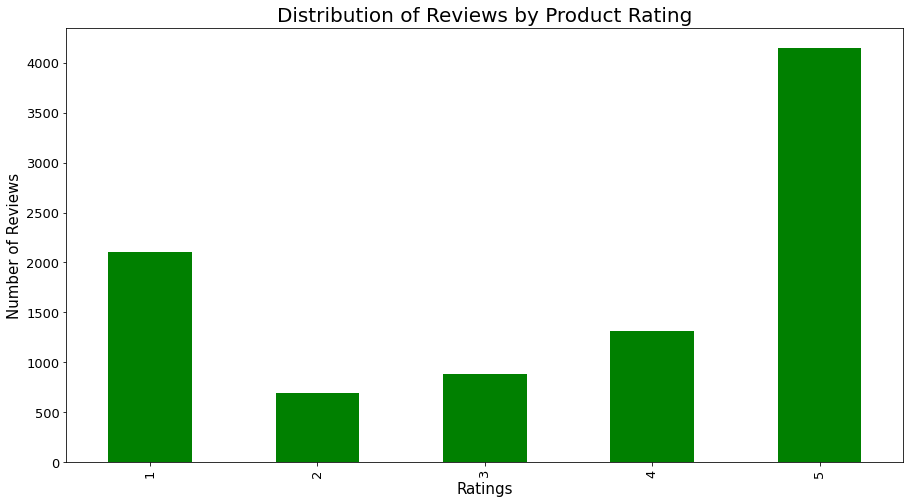

In [81]:
# plot the data
ax1 = ratings_review.plot(kind='bar', figsize=(15,8), color="green", fontsize = 13);
ax1.set_alpha(0.8)
ax1.set_title('Distribution of Reviews by Product Rating', fontsize = 20)
ax1.set_ylabel("Number of Reviews", fontsize = 15);
ax1.set_xlabel("Ratings", fontsize = 15 )
plt.show();


Mobile phones with higher rating receive the highest number of reviews followed by phones with the least review rating.

### 6.3. Brands with the highest reviews and with distribution of average prices

In [82]:
# Group relevant columns
brand_reviews = df.groupby('Brand')['Review'].count().sort_values(ascending = False).head(10)
brand_prices = df.groupby('Brand')['Price'].max().sort_values(ascending = False).head(10)

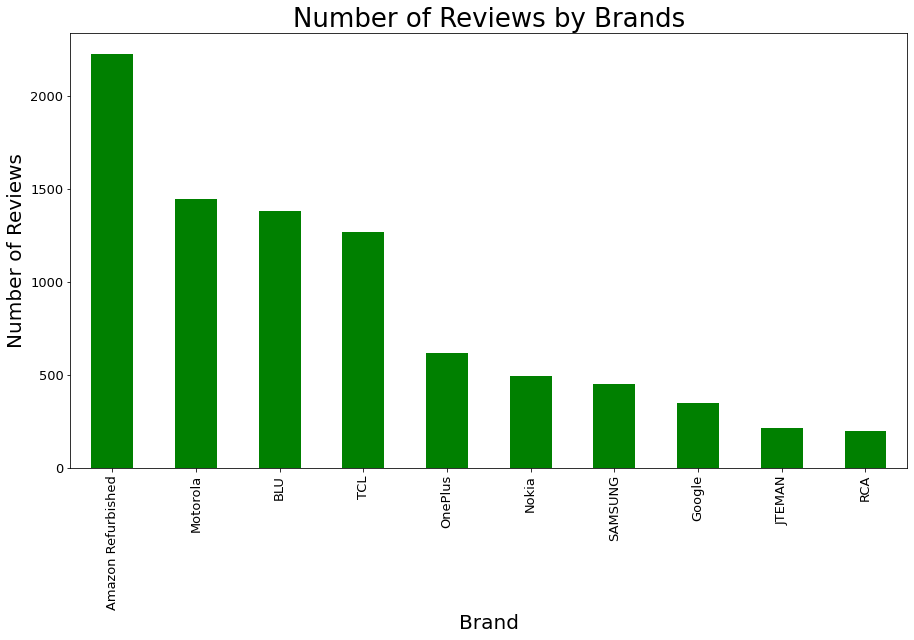

In [83]:
# Plot the data
ax1 = brand_reviews.plot(kind = 'bar', figsize = (15,8), color = 'green', fontsize = 13);
ax1.set_alpha(0.8)
ax1.set_title('Number of Reviews by Brands', fontsize = 26)
ax1.set_ylabel('Number of Reviews', fontsize = 20);
ax1.set_xlabel('Brand', fontsize = 20)
plt.show();



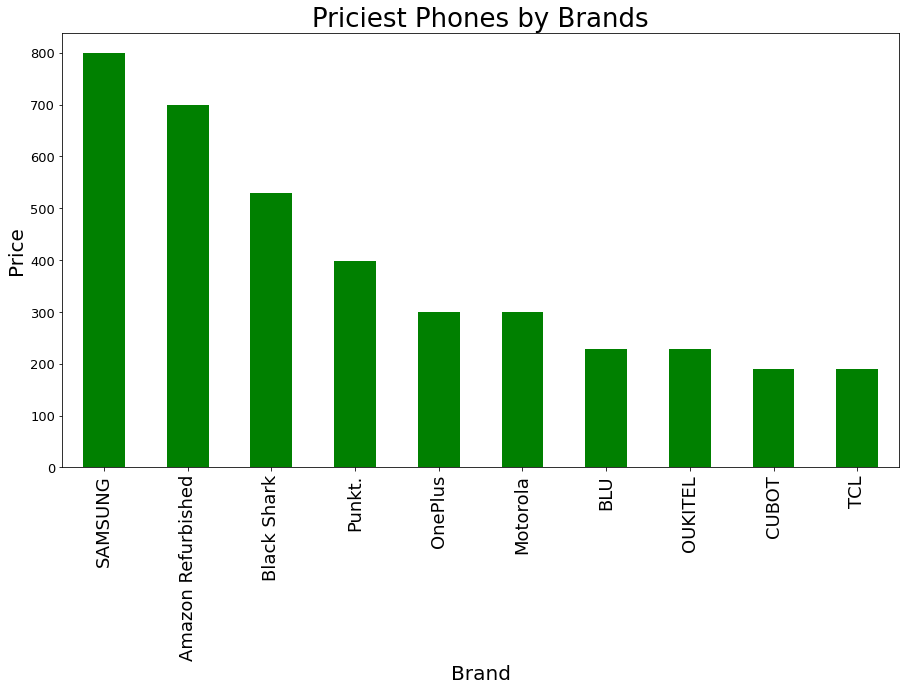

In [84]:
ax2 = brand_prices.plot(kind = 'bar', figsize = (15,8), color = 'green', fontsize = 13);
ax2.set_alpha(0.8)
ax2.set_title('Priciest Phones by Brands', fontsize = 26)
ax2.set_ylabel('Price', fontsize = 20);
ax2.set_xlabel('Brand', fontsize = 20)
plt.xticks(fontsize = 18)
plt.show();

Refurbished phones have the highest number of reviews while Samsung phones have the priciest phones. Samsung is one of the top phone brands in the world and with high performance, which could explain the high prices of its models.

### 6.4. Word cloud of the most-used words in reviews.

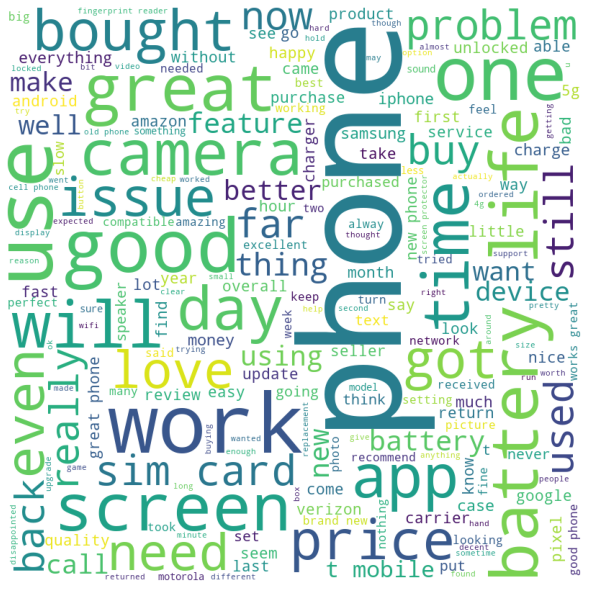

In [85]:
# Plot a word cloud 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.Review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show() 

good, great, battery price, issue and work are some of the words that pop up more in the reviews

### 6.5. Trend of reviews over the years

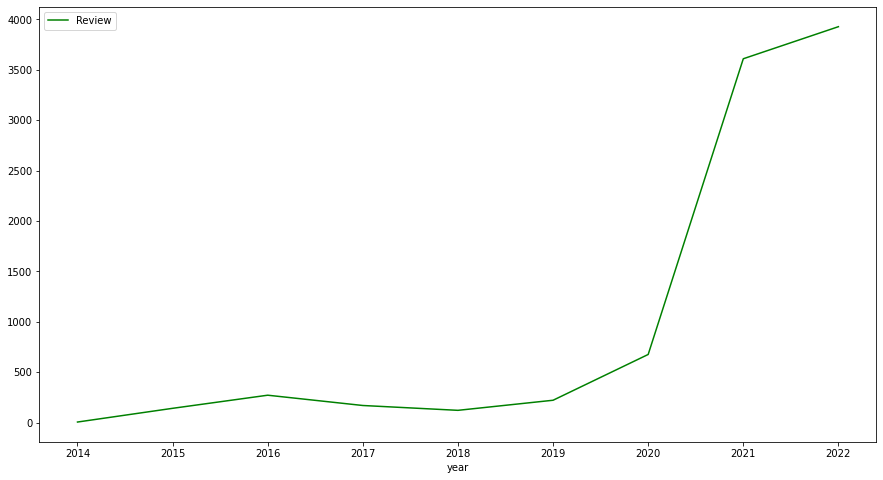

In [86]:
# Create a new dataframe to use while maintaining the original
new_df = df.copy()

# Extract year from the new dataframe
new_df['year'] = new_df['Review Date'].dt.year

# Group by relevant columns
review_date = new_df.groupby('year')['Review'].count()
review_date = pd.DataFrame(review_date).reset_index()

# plot the data
review_date.plot.line(x = 'year', y = 'Review', color = 'green', figsize=(15, 8));


The rate of customer reviews took a major increase from 2020. This could be attributed to the Covid Pandemic where people spent lots of time indoors and online shopping was at an all time high.

### 6.6. Relationship between price and Ratings

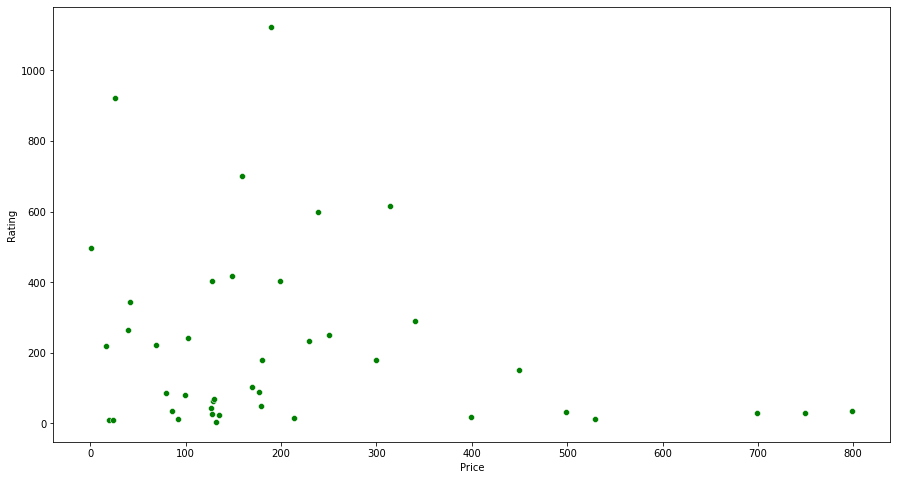

In [87]:
# Group by relevant columns
review_price = new_df.groupby('Price')['Rating'].count()
review_price = pd.DataFrame(review_price).reset_index()

# Plot the data
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(x = 'Price', y = 'Rating', data = review_price, color = 'green')
plt.show();

The scatter plot above does not show a correlation between price and rating.

## Vader Analysis

In [88]:
df["id"] = df.index + 1
df = df.reindex(columns=['id', 'Model_Type', 'Brand', 'Price', 'Review Date', 
                         'Rating', 'Review Title', 'Review'])
df.drop("Review Date", axis=1, inplace=True)
df.head()

,id,Model_Type,Brand,Price,Rating,Review Title,Review
0,1,RCA Reno,RCA,69,4,".. not what ordered, not New... but it works so far","So first off...it's not what I ordered, but I don't really care as it's a burner.I ordered the ""Gold"" version. I got a ""Black"" version. Hardware and (assumed) function are the same. I say assumed, as I have not used it for the purposes it was purchased for.However, as far as the ""Phone"" goes, it's functional, and does what most modern phones do. It was running Android 10, so not much to complain about, but no stock Service provider forced apps, other than the ones that come with the custom RCA ROM. Can't be bothered to root it, but can be done fairly easily, if you look in the usual places for info.I totally missed the ""like new"" as condition!! Can't really be surprised at the price point, and though the wrong color, looks pristine! No scuffs, bumps, cracks or scrapes. The only way is know it was not new, is the package ( see pict).Totally on me. Still...if wrong color..might other things, as others have pointed out, raise up and bite me?It's a burner, not intended to fly the space shuttle remotely over a VPN...We will see I guess ..Now, the good stuff, what there is of it.It's an Android. Works(so far) out of the box, with minimal need for difficult set up or account creation. The Android process walks you through set up. Android 10 + have a number of security and privacy configurations that have been brought to the front, so it's much easier to manage privacy, tracking, and security options than previous Android os's.It's not fast. In fact, with stock build that came with device, even prior to the one app installed so far, I have seen lag time between action and response. Sooo.. do t think this device is gonna let you run 15 appa, split screen, while playing music and talking to your Memaw...it won't. Not RCAs fault, that memory and chip. Still, compared to a phone that is 3 yrs older with similar hardware, it's slow. I don't care. You may... Consider your sled advised, if you get this far.Otherwise, though a bit small on screen size, I like it in the limited time I've messed with it.Of note for some, it doesn't have gorilla glass, obviously for thai Price point. It did however come with a Pre-installed screen protector. Did come with, as far as I can tell a new, mostly charged battery, basic headphones, and a... pretty ...no, super basic clear rubber/ plastic case cover. So there is that.Not alot of info here, sorry, I'll know more when I use it instead of the $700 daily phone.It will do what you'd expect a phone to do, duel sim, yadada, and though not advertised, apparently takes up to a128gb micro SIM....Not trusting that info, waiting on a 64gm SIM figuring it should work.If it sucks or goes pear shaped at the wrong time ..I'll update this review."
2,3,RCA Reno,RCA,69,3,Will not work on T-Mobile sysem!,"New phone write up indicates T-Mobile system compatible.Took phone to local office to activate. they took the chip from my currently active on system I_Phone and which had previously been in an Android and had worked in both. On turning the RCA Reno on the Agent indicated ""this phone will not work on T-Mobile system' but then tried several actions to see if he could get it to do so, All attempts failed and he indicated I needed a different phone.WHAT IS THE ISSUE HERE?"
3,4,RCA Reno,RCA,69,3,A burner or for a kid,"I use this as a burner w/o a sim card in it. Just some things others may find helpful, the android 10 on this phone is a lite or stripped down version. The camera quality is horrible, I had better cameras 20 years ago. The phone came with a charger and a gel case. To be honest if you are looking for a main phone you would be better off saving up some extra money and buying a used mid-tier phone that can support full android 10 and has better specs and features. This is low end phone and would be fine as a backup/burner. Beyond that it is RCA made in China at a low cost. It i

In [89]:
# creating polarity scores on the entire dataset
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
from tqdm.notebook import tqdm
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row["Review"]
  id = row["id"]
  res[id] = sia.polarity_scores(text)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  0%|          | 0/9144 [00:00<?, ?it/s]

In [90]:
# populating results into a df
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns={"index":"id"})
vader_df = vader.merge(df, how="left")

In [96]:
# sentiment scores combined with the meta data


# pd.set_option('display.max_colwidth',10000)
vader_df.head()

,id,neg,neu,pos,compound,Model_Type,Brand,Price,Rating,Review Title,Review
0,1,0.107,0.795,0.098,-0.5514,RCA Reno,RCA,69,4,".. not what ordered, not New... but it works so far","So first off...it's not what I ordered, but I don't really care as it's a burner.I ordered the ""Gold"" version. I got a ""Black"" version. Hardware and (assumed) function are the same. I say assumed, as I have not used it for the purposes it was purchased for.However, as far as the ""Phone"" goes, it's functional, and does what most modern phones do. It was running Android 10, so not much to complain about, but no stock Service provider forced apps, other than the ones that come with the custom RCA ROM. Can't be bothered to root it, but can be done fairly easily, if you look in the usual places for info.I totally missed the ""like new"" as condition!! Can't really be surprised at the price point, and though the wrong color, looks pristine! No scuffs, bumps, cracks or scrapes. The only way is know it was not new, is the package ( see pict).Totally on me. Still...if wrong color..might other things, as others have pointed out, raise up and bite me?It's a burner, not intended to fly the space shuttle remotely over a VPN...We will see I guess ..Now, the good stuff, what there is of it.It's an Android. Works(so far) out of the box, with minimal need for difficult set up or account creation. The Android process walks you through set up. Android 10 + have a number of security and privacy configurations that have been brought to the front, so it's much easier to manage privacy, tracking, and security options than previous Android os's.It's not fast. In fact, with stock build that came with device, even prior to the one app installed so far, I have seen lag time between action and response. Sooo.. do t think this device is gonna let you run 15 appa, split screen, while playing music and talking to your Memaw...it won't. Not RCAs fault, that memory and chip. Still, compared to a phone that is 3 yrs older with similar hardware, it's slow. I don't care. You may... Consider your sled advised, if you get this far.Otherwise, though a bit small on screen size, I like it in the limited time I've messed with it.Of note for some, it doesn't have gorilla glass, obviously for thai Price point. It did however come with a Pre-installed screen protector. Did come with, as far as I can tell a new, mostly charged battery, basic headphones, and a... pretty ...no, super basic clear rubber/ plastic case cover. So there is that.Not alot of info here, sorry, I'll know more when I use it instead of the $700 daily phone.It will do what you'd expect a phone to do, duel sim, yadada, and though not advertised, apparently takes up to a128gb micro SIM....Not trusting that info, waiting on a 64gm SIM figuring it should work.If it sucks or goes pear shaped at the wrong time ..I'll update this review."
1,3,0.055,0.924,0.021,-0.6118,RCA Reno,RCA,69,3,Will not work on T-Mobile sysem!,"New phone write up indicates T-Mobile system compatible.Took phone to local office to activate. they took the chip from my currently active on system I_Phone and which had previously been in an Android and had worked in both. On turning the RCA Reno on the Agent indicated ""this phone will not work on T-Mobile system' but then tried several actions to see if he could get it to do so, All attempts failed and he indicated I needed a different phone.WHAT IS THE ISSUE HERE?"
2,4,0.054,0.771,0.175,0.9477,RCA Reno,RCA,69,3,A burner or for a kid,"I use this as a burner w/o a sim card in it. Just some things others may find helpful, the android 10 on this phone is a lite or stripped down version. The camera quality is horrible, I had better cameras 20 years ago. The phone came with a charger and a gel case. To be honest if you are looking for a main phone you would be better off saving up some extra money and buying a used mid-tier phone that can support full android 10 and has better specs and features. This is low end p

Making assumptions on our data, if rating is 5, then it is likely to be a more positive value than a rating of 1.

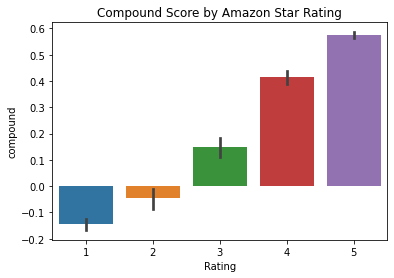

In [92]:
# plotting a bar plot to compare rating and compound value to see if the ratings align with the sentiment scores
df_sorted = vader_df.sort_values('Rating')
ax = sns.barplot(data=df_sorted, x = "Rating", y="compound")
ax.set_title("Compound Score by Amazon Star Rating")
plt.show()

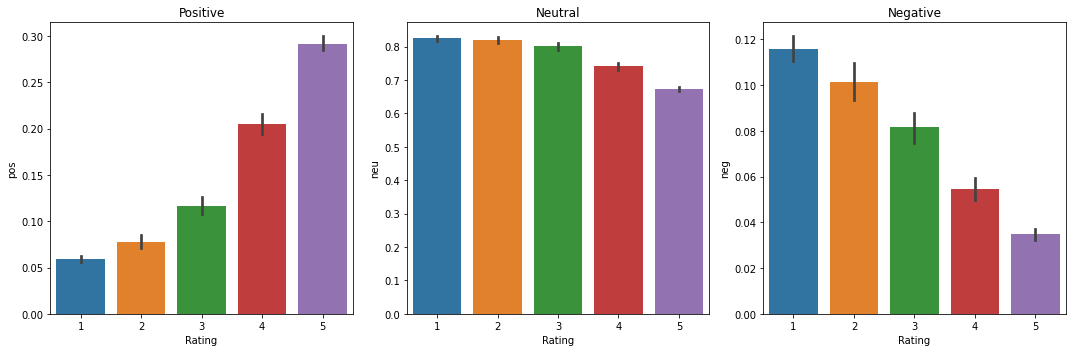

In [93]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=df_sorted, x = "Rating", y="pos", ax=axs[0])
sns.barplot(data=df_sorted, x = "Rating", y="neu", ax=axs[1])
sns.barplot(data=df_sorted, x = "Rating", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

The more positive the compound value, the higher the Ranking score. Positive values represent high rankings of 4 and 5 while low rankings of 1 and 2 mainly show negative values. This proves the assumption made on the data.

In [97]:
# Exploring vader as a model
analyzer = SentimentIntensityAnalyzer()

In [102]:
df["scores"] = df["Review"].apply(lambda review : analyzer.polarity_scores(review))
df["compound"] = df["scores"].apply(lambda score_dict :score_dict["compound"])
df["label"] = df["compound"].apply(lambda c : "positive" if c >= 0.05 else "negative" if c <= -0.05 else "neutral")

df.head()

,id,Model_Type,Brand,Price,Rating,Review Title,Review,scores,compound,label
0,1,RCA Reno,RCA,69,4,".. not what ordered, not New... but it works so far","So first off...it's not what I ordered, but I don't really care as it's a burner.I ordered the ""Gold"" version. I got a ""Black"" version. Hardware and (assumed) function are the same. I say assumed, as I have not used it for the purposes it was purchased for.However, as far as the ""Phone"" goes, it's functional, and does what most modern phones do. It was running Android 10, so not much to complain about, but no stock Service provider forced apps, other than the ones that come with the custom RCA ROM. Can't be bothered to root it, but can be done fairly easily, if you look in the usual places for info.I totally missed the ""like new"" as condition!! Can't really be surprised at the price point, and though the wrong color, looks pristine! No scuffs, bumps, cracks or scrapes. The only way is know it was not new, is the package ( see pict).Totally on me. Still...if wrong color..might other things, as others have pointed out, raise up and bite me?It's a burner, not intended to fly the space shuttle remotely over a VPN...We will see I guess ..Now, the good stuff, what there is of it.It's an Android. Works(so far) out of the box, with minimal need for difficult set up or account creation. The Android process walks you through set up. Android 10 + have a number of security and privacy configurations that have been brought to the front, so it's much easier to manage privacy, tracking, and security options than previous Android os's.It's not fast. In fact, with stock build that came with device, even prior to the one app installed so far, I have seen lag time between action and response. Sooo.. do t think this device is gonna let you run 15 appa, split screen, while playing music and talking to your Memaw...it won't. Not RCAs fault, that memory and chip. Still, compared to a phone that is 3 yrs older with similar hardware, it's slow. I don't care. You may... Consider your sled advised, if you get this far.Otherwise, though a bit small on screen size, I like it in the limited time I've messed with it.Of note for some, it doesn't have gorilla glass, obviously for thai Price point. It did however come with a Pre-installed screen protector. Did come with, as far as I can tell a new, mostly charged battery, basic headphones, and a... pretty ...no, super basic clear rubber/ plastic case cover. So there is that.Not alot of info here, sorry, I'll know more when I use it instead of the $700 daily phone.It will do what you'd expect a phone to do, duel sim, yadada, and though not advertised, apparently takes up to a128gb micro SIM....Not trusting that info, waiting on a 64gm SIM figuring it should work.If it sucks or goes pear shaped at the wrong time ..I'll update this review.","{'neg': 0.107, 'neu': 0.795, 'pos': 0.098, 'compound': -0.5514}",-0.5514,negative
2,3,RCA Reno,RCA,69,3,Will not work on T-Mobile sysem!,"New phone write up indicates T-Mobile system compatible.Took phone to local office to activate. they took the chip from my currently active on system I_Phone and which had previously been in an Android and had worked in both. On turning the RCA Reno on the Agent indicated ""this phone will not work on T-Mobile system' but then tried several actions to see if he could get it to do so, All attempts failed and he indicated I needed a different phone.WHAT IS THE ISSUE HERE?","{'neg': 0.055, 'neu': 0.924, 'pos': 0.021, 'compound': -0.6118}",-0.6118,negative
3,4,RCA Reno,RCA,69,3,A burner or for a kid,"I use this as a burner w/o a sim card in it. Just some things others may find helpful, the android 10 on this phone is a lite or stripped down version. The camera quality is horrible, I had better cameras 20 years ago. The phone came with a charger and a gel case. To be honest if you are looking for a main phone you would be better off saving up some extra money and buying a used mid-tier p

In [105]:
df["label"].value_counts()

positive    5723
negative    2210
neutral     1211
Name: label, dtype: int64

Text(0.5, 1.0, 'Distribution of Sentiment Score')

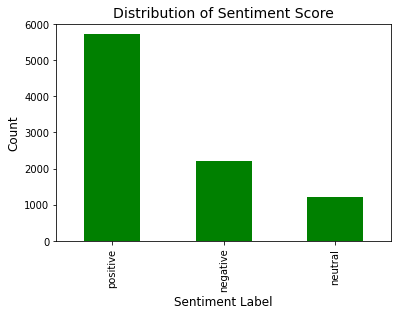

In [106]:
df["label"].value_counts().plot(kind="bar", color = "g")
plt.xlabel("Sentiment Label", size=12)
plt.ylabel("Count", size=12)
plt.title("Distribution of Sentiment Score", size=14)

# 7. Implementing the Solution

## 7.1 Preprocessing

- tokenization
- lowercasing our words
- lemmatization/stemming
- vectorization

The first step will be to perform a contraction the reviews, to make sure that our words are expanded, for example, `isn't` would be expanded to `is not`

In [ ]:
# fixing contractions
def text_contraction(text):
  
  # creating an empty list
  expanded_words = []

  for word in text.split():
    # using contractions.fix to expand the shortened words
    expanded_words.append(contractions.fix(word))  
    
  expanded_text = ' '.join(expanded_words)

  return expanded_text

In [ ]:
# apply the contraction funtion to our reviews

df['Review Title'] = df['Review Title'].map(lambda x: text_contraction(x))
df['Review'] = df['Review'].map(lambda x: text_contraction(x))
df.head()

,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review
0,RCA Reno,RCA,69,2022-02-11,4,".. not what ordered, not New... but it works s...","So first off...it is not what I ordered, but I..."
2,RCA Reno,RCA,69,2022-06-07,3,Will not work on T-Mobile sysem!,New phone write up indicates T-Mobile system c...
3,RCA Reno,RCA,69,2022-04-14,3,A burner or for a kid,I use this as a burner w/o a sim card in it. J...
4,RCA Reno,RCA,69,2022-08-13,4,It works okay,It works fine
5,RCA Reno,RCA,69,2022-05-10,3,Phone,"So far I do not like this phone at all, I thre..."


In [ ]:
sentence = 'Today is Monday, 3 pm'

punctuation = string.punctuation

  # lower case our string
  # text = str([word.lower() for word in t
  # remove the digits
sentence = re.sub('\d', '', sentence)

  # cretae our word tokens
tokens = word_tokenize(sentence)

print(tokens)

['Today', 'is', 'Monday', ',', 'pm']


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
# grab the stop words from stopwords.words('english)
#stopwords_list = stopwords.words('english')
#stopwords_list += punctuation

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

# remove the stop words
clean_list = [word.lower() for word in tokens if word.lower() not in stopwords_list]

print(clean_list)

['today', 'monday', 'pm']


In [ ]:
# tokenization

def tokenize_words(text):
  # grab all the punctuations
  punctuation = string.punctuation

  # lower case our string
  # text = str([word.lower() for word in t
  # remove the digits
  text = re.sub('\d', '', text)

  # cretae our word tokens
  tokens = word_tokenize(text)

  # grab the stop words from stopwords.words('english)
  # stopwords_list = stopwords.words('english')
  # stopwords_list += punctuation
  stopwords_list = stopwords.words('english') + list(string.punctuation)
  stopwords_list += ["''", '""', '...', '``', '..', '....']

  # remove the stop words
  clean_list = [word.lower() for word in tokens if word.lower() not in stopwords_list]
  
  # return a clean tokenized set
  return clean_list

In [ ]:
df['Review'] = df['Review'].map(lambda x: tokenize_words(x))
df['Review Title'] = df['Review Title'].map(lambda x: tokenize_words(x))
df.head()

,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review
0,RCA Reno,RCA,69,2022-02-11,4,"[ordered, new, works, far]","[first, ordered, really, care, burner.i, order..."
2,RCA Reno,RCA,69,2022-06-07,3,"[work, t-mobile, sysem]","[new, phone, write, indicates, t-mobile, syste..."
3,RCA Reno,RCA,69,2022-04-14,3,"[burner, kid]","[use, burner, w/o, sim, card, things, others, ..."
4,RCA Reno,RCA,69,2022-08-13,4,"[works, okay]","[works, fine]"
5,RCA Reno,RCA,69,2022-05-10,3,[phone],"[far, like, phone, threw, booklet, accident, c..."


After tokenization, lemmatization is done to decompose the words to their most basic forms(lemma), but before that, tagging the words is done to ensure that the lemmatization gets the parts of speech represented by the words correctly.

In [ ]:
# create a function that takes in the nltk POS tags
# and transforms them to wordnet tags
def wordnet_pos(word_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if word_tag.startswith('J'):
        return wordnet.ADJ
    elif word_tag.startswith('V'):
        return wordnet.VERB
    elif word_tag.startswith('N'):
        return wordnet.NOUN
    elif word_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
# check to see how the word tag performs
sentence = df["Review"][0]
pos_tag(sentence)

[('first', 'RB'),
 ('ordered', 'VBN'),
 ('really', 'RB'),
 ('care', 'VB'),
 ('burner.i', 'NN'),
 ('ordered', 'VBN'),
 ('gold', 'JJ'),
 ('version', 'NN'),
 ('got', 'VBD'),
 ('black', 'JJ'),
 ('version', 'NN'),
 ('hardware', 'NN'),
 ('assumed', 'JJ'),
 ('function', 'NN'),
 ('say', 'VBP'),
 ('assumed', 'VBN'),
 ('used', 'JJ'),
 ('purposes', 'NNS'),
 ('purchased', 'VBD'),
 ('for.however', 'RB'),
 ('far', 'RB'),
 ('phone', 'NN'),
 ('goes', 'VBZ'),
 ('functional', 'JJ'),
 ('modern', 'JJ'),
 ('phones', 'NNS'),
 ('running', 'VBG'),
 ('android', 'RB'),
 ('much', 'JJ'),
 ('complain', 'NN'),
 ('stock', 'NN'),
 ('service', 'NN'),
 ('provider', 'NN'),
 ('forced', 'VBD'),
 ('apps', 'JJ'),
 ('ones', 'NNS'),
 ('come', 'VBP'),
 ('custom', 'NN'),
 ('rca', 'NN'),
 ('rom', 'NN'),
 ('bothered', 'VBD'),
 ('root', 'NN'),
 ('done', 'VBN'),
 ('fairly', 'RB'),
 ('easily', 'RB'),
 ('look', 'VB'),
 ('usual', 'JJ'),
 ('places', 'NNS'),
 ('info.i', 'VBP'),
 ('totally', 'RB'),
 ('missed', 'VBN'),
 ('like', 'IN'),
 (

In [ ]:
# inastantiate the lemmatizer
lemmatizer = WordNetLemmatizer() 

In [ ]:
df['Review'][0:2]

0    [first, ordered, really, care, burner.i, order...
2    [new, phone, write, indicates, t-mobile, syste...
Name: Review, dtype: object

In [ ]:
def word_lemma(text):
    '''
    Translate the text POS tags to Word net tags then pass it to the lemmatizer
    
    '''
    # get the pos tags for the text
    word_pos_tags = pos_tag(text)
    
    # translate the pos tags to word net tags
    word_net_tag = [(text[0], wordnet_pos(text[1])) for text in word_pos_tags]
    
    # Pass the text with the wordnet tags to the lemmatizer
    lemma_word = [lemmatizer.lemmatize(text[0], text[1]) for text in word_net_tag]
    
    return lemma_word
    

In [ ]:
nltk.download('all')
df['Review'] = df['Review'].apply(word_lemma)
df['Review Title'] = df['Review Title'].apply(word_lemma)
df.head()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.

,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review
0,RCA Reno,RCA,69,2022-02-11,4,"[ordered, new, work, far]","[first, order, really, care, burner.i, order, ..."
2,RCA Reno,RCA,69,2022-06-07,3,"[work, t-mobile, sysem]","[new, phone, write, indicate, t-mobile, system..."
3,RCA Reno,RCA,69,2022-04-14,3,"[burner, kid]","[use, burner, w/o, sim, card, thing, others, m..."
4,RCA Reno,RCA,69,2022-08-13,4,"[work, okay]","[work, fine]"
5,RCA Reno,RCA,69,2022-05-10,3,[phone],"[far, like, phone, throw, booklet, accident, c..."


Frequency Distribution Plot

In [ ]:
# create the frequency distribution plot
sample = df['Review']
freq1_dist = []

for review in sample:
    freq1_dist.extend(review)
    
fdist = FreqDist(freq1_dist)
plt.figure(figsize=(15, 10))
fdist.plot(50);

In [ ]:
# display the count of the first 200 texts
word_frequency = fdist.most_common(200)
word_frequency

[('phone', 14276),
 ('work', 3418),
 ('use', 2896),
 ('get', 2712),
 ('good', 2619),
 ('great', 2348),
 ('battery', 2246),
 ('like', 1985),
 ('buy', 1799),
 ('one', 1766),
 ('would', 1719),
 ('screen', 1660),
 ('new', 1384),
 ('time', 1309),
 ('camera', 1294),
 ('well', 1282),
 ('g', 1277),
 ('go', 1275),
 ('day', 1236),
 ('call', 1177),
 ('price', 1158),
 ('life', 1151),
 ('sim', 1088),
 ('charge', 1034),
 ('need', 1030),
 ('card', 1021),
 ('come', 1018),
 ('make', 996),
 ('take', 972),
 ('even', 964),
 ('look', 956),
 ('really', 909),
 ('love', 903),
 ('could', 857),
 ('back', 851),
 ('issue', 829),
 ('say', 805),
 ('want', 798),
 ('return', 797),
 ('purchase', 794),
 ('old', 744),
 ('quality', 733),
 ('also', 714),
 ('problem', 699),
 ('thing', 687),
 ('feature', 677),
 ('much', 676),
 ('last', 676),
 ('far', 655),
 ('fast', 655),
 ('still', 653),
 ('try', 648),
 ('everything', 629),
 ('samsung', 629),
 ('apps', 619),
 ('nice', 614),
 ('pixel', 596),
 ('iphone', 586),
 ('find', 581)

Word Vectorization

In [ ]:
# convert the list into a string

X = df['Review']

X = X.map(lambda x: ' '.join(map(str, x)))
X

In [ ]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer() 

# fit the vecorizer on the dataset
vectorizer.fit_transform(X)

# 8. Challenging the Solution

# 9. Conclusions

# 10. Recommendations